## Import modules and libraries

In [1]:
import SimpleITK as sitk
import glob
import re
import nibabel as nib
import nilearn as nl
import nilearn.plotting as nlplt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import os
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python import keras
print(keras.__version__)

2.9.1
Num GPUs Available:  1
2.6.0


In [3]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.python.keras.metrics import MeanIoU

In [4]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU


In [5]:
import keras
from keras import backend as K

## Custom image loader for model

In [6]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [7]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


### Define the image generators for training and validation

In [21]:
train_img_dir = "train_val_test/train/images/"
train_mask_dir = "train_val_test/train/masks/"

val_img_dir = "train_val_test/val/images/"
val_mask_dir = "train_val_test/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [22]:
batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


### Loss, metrics and optimizer used for training

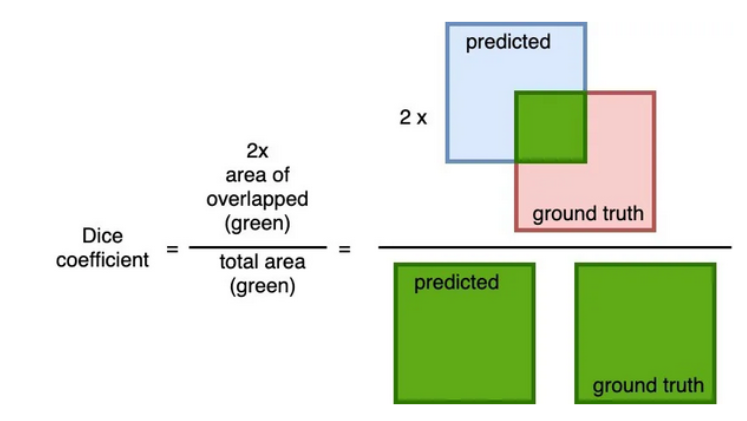

In [14]:
#wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

#iou = true_positives / (true_positives + false_positives + false_negatives)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [6]:
callbacks = [
             keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                                           patience=3, verbose=1, mode='auto'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
             keras.callbacks.ModelCheckpoint(filepath = 'saved_models/Unet/model_.{epoch:02d}-{val_loss:.6f}.h5',
                             verbose=0, save_best_only=True, save_weights_only = True),
             keras.callbacks.CSVLogger('saved_models/Unet/training_log/training_unet.csv', separator=",", append=True)
             ]

## 3D U-Net Model
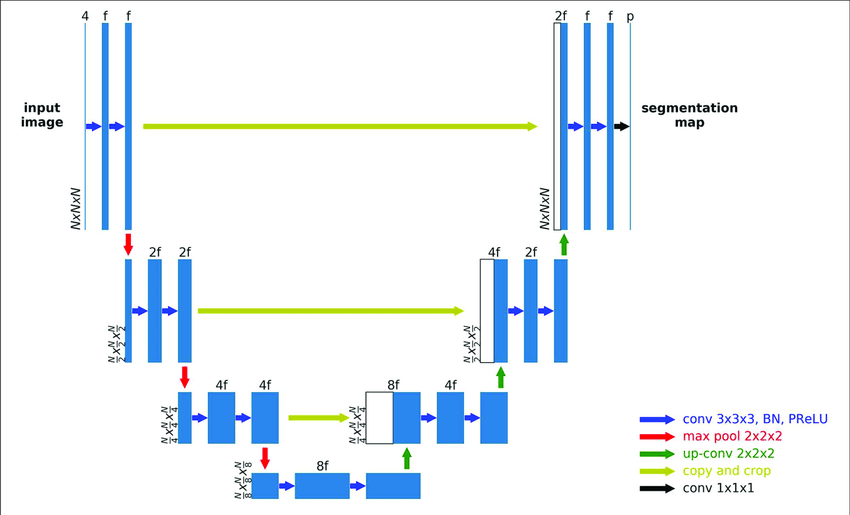

## **3D U-Net**

In [7]:
kernel_initializer =  'he_uniform' 

In [31]:
def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes,dropout=0.1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(dropout)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(dropout)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(dropout)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(dropout)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(dropout)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(dropout)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(dropout)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(dropout)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(dropout)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
     
    model.summary()
    
    return model

In [9]:

model = unet_model(128, 128, 128, 3, 4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

                                                                                                  
 conv3d_12 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_1[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_6 (Dropout)            (None, 32, 32, 32,   0           ['conv3d_12[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_13 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_6[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_tr

### Fit the model 

In [54]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

                                                                                                  
 conv3d_29 (Conv3D)             (None, 16, 16, 16,   884864      ['concatenate_4[0][0]']          
                                128)                                                              
                                                                                                  
 dropout_14 (Dropout)           (None, 16, 16, 16,   0           ['conv3d_29[0][0]']              
                                128)                                                              
                                                                                                  
 conv3d_30 (Conv3D)             (None, 16, 16, 16,   442496      ['dropout_14[0][0]']             
                                128)                                                              
                                                                                                  
 conv3d_tr

NameError: name 'optim' is not defined

In [24]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('unet.hdf5')

Epoch 1/40
240/240 [==============================] - 165s 623ms/step - loss: -2.4465 - accuracy: 0.3954 - iou_score: 0.2187 - f1-score: 0.2942 - val_loss: -5.6723 - val_accuracy: 0.9652 - val_iou_score: 0.4856 - val_f1-score: 0.5802 - lr: 1.0000e-04
Epoch 2/40
240/240 [==============================] - 150s 623ms/step - loss: -8.5043 - accuracy: 0.9767 - iou_score: 0.5599 - f1-score: 0.6558 - val_loss: -7.1947 - val_accuracy: 0.9731 - val_iou_score: 0.5170 - val_f1-score: 0.5962 - lr: 1.0000e-04
Epoch 3/40
240/240 [==============================] - 150s 624ms/step - loss: -9.6035 - accuracy: 0.9796 - iou_score: 0.5997 - f1-score: 0.6961 - val_loss: -6.7541 - val_accuracy: 0.9724 - val_iou_score: 0.5051 - val_f1-score: 0.5826 - lr: 1.0000e-04
Epoch 4/40
240/240 [==============================] - 150s 626ms/step - loss: -9.9455 - accuracy: 0.9806 - iou_score: 0.6131 - f1-score: 0.7090 - val_loss: -7.7729 - val_accuracy: 0.9763 - val_iou_score: 0.5424 - val_f1-score: 0.6235 - lr: 1.0000e

## **3D U-Net + Batch-Normalization**

In [7]:
kernel_initializer =  'he_uniform' 

In [1]:
def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes,dropout=0.1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(dropout)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    b1 = BatchNormalization()(c1)
    p1 = MaxPooling3D((2, 2, 2))(b1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(dropout)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    b2 = BatchNormalization()(c2)
    p2 = MaxPooling3D((2, 2, 2))(b2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(dropout)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    b3 = BatchNormalization()(c3)
    p3 = MaxPooling3D((2, 2, 2))(b3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(dropout)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    b4 = BatchNormalization()(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(b4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(dropout)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    b5 = BatchNormalization()(c5) 
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(b5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(dropout)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    b7 = BatchNormalization()(u7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(b7)
    c7 = Dropout(dropout)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    b8 = BatchNormalization()(u8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(b8)
    c8 = Dropout(dropout)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    b9 = BatchNormalization()(u9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(b9)
    c9 = Dropout(dropout)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
     
    model.summary()
    
    return model

In [9]:

model = unet_model(128, 128, 128, 3, 4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

                                                                                                  
 conv3d_10 (Conv3D)             (None, 16, 16, 16,   884864      ['concatenate[0][0]']            
                                128)                                                              
                                                                                                  
 dropout_5 (Dropout)            (None, 16, 16, 16,   0           ['conv3d_10[0][0]']              
                                128)                                                              
                                                                                                  
 conv3d_11 (Conv3D)             (None, 16, 16, 16,   442496      ['dropout_5[0][0]']              
                                128)                                                              
                                                                                                  
 conv3d_tr

In [23]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('unetdo2bn.hdf5')

Epoch 1/40
240/240 [==============================] - 164s 621ms/step - loss: 0.9176 - accuracy: 0.8424 - iou_score: 0.3496 - f1-score: 0.4294 - val_loss: 0.8664 - val_accuracy: 0.9616 - val_iou_score: 0.4950 - val_f1-score: 0.5921 - lr: 1.0000e-04
Epoch 2/40
240/240 [==============================] - 149s 621ms/step - loss: 0.8471 - accuracy: 0.9758 - iou_score: 0.5530 - f1-score: 0.6523 - val_loss: 0.8572 - val_accuracy: 0.9737 - val_iou_score: 0.5317 - val_f1-score: 0.6181 - lr: 1.0000e-04
Epoch 3/40
240/240 [==============================] - 149s 622ms/step - loss: 0.8377 - accuracy: 0.9787 - iou_score: 0.5871 - f1-score: 0.6853 - val_loss: 0.8612 - val_accuracy: 0.9747 - val_iou_score: 0.5203 - val_f1-score: 0.6043 - lr: 1.0000e-04
Epoch 4/40
240/240 [==============================] - ETA: 0s - loss: 0.8327 - accuracy: 0.9802 - iou_score: 0.6059 - f1-score: 0.7033
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
240/240 [==============================] 

## **3D U-Net + Batch-Normalization + Weighted Loss Function**

In [8]:
kernel_initializer =  'he_uniform' 

In [9]:
def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes,dropout=0.1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(dropout)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    b1 = BatchNormalization()(c1)
    p1 = MaxPooling3D((2, 2, 2))(b1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(dropout)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    b2 = BatchNormalization()(c2)
    p2 = MaxPooling3D((2, 2, 2))(b2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(dropout)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    b3 = BatchNormalization()(c3)
    p3 = MaxPooling3D((2, 2, 2))(b3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(dropout)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    b4 = BatchNormalization()(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(b4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(dropout)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    b5 = BatchNormalization()(c5) 
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(b5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(dropout)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    b7 = BatchNormalization()(u7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(b7)
    c7 = Dropout(dropout)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    b8 = BatchNormalization()(u8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(b8)
    c8 = Dropout(dropout)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    b9 = BatchNormalization()(u9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(b9)
    c9 = Dropout(dropout)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
     
    model.summary()
    
    return model

In [10]:

model = unet_model(128, 128, 128, 3, 4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

                                                                                                  
 conv3d_10 (Conv3D)             (None, 16, 16, 16,   884864      ['concatenate[0][0]']            
                                128)                                                              
                                                                                                  
 dropout_5 (Dropout)            (None, 16, 16, 16,   0           ['conv3d_10[0][0]']              
                                128)                                                              
                                                                                                  
 conv3d_11 (Conv3D)             (None, 16, 16, 16,   442496      ['dropout_5[0][0]']              
                                128)                                                              
                                                                                                  
 conv3d_tr

In [17]:
from IPython.display import Image, display
display(Image(url='unetbnwt.png', width=200, unconfined=True))

In [20]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('train_val_test/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    #print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)
print(wt0,wt1,wt2,wt3)

0.26 22.32 22.32 26.47


In [22]:
#wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

#iou = true_positives / (true_positives + false_positives + false_negatives)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [20]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('unetdo0.1.hdf5')

Epoch 1/40
240/240 [==============================] - 158s 607ms/step - loss: 0.5470 - accuracy: 0.9385 - iou_score: 0.3951 - f1-score: 0.4677 - val_loss: 0.4135 - val_accuracy: 0.9649 - val_iou_score: 0.5130 - val_f1-score: 0.6076 - lr: 1.0000e-04
Epoch 2/40
240/240 [==============================] - 146s 607ms/step - loss: 0.3958 - accuracy: 0.9700 - iou_score: 0.5292 - f1-score: 0.6248 - val_loss: 0.3996 - val_accuracy: 0.9634 - val_iou_score: 0.5252 - val_f1-score: 0.6207 - lr: 1.0000e-04
Epoch 3/40
240/240 [==============================] - 146s 609ms/step - loss: 0.3570 - accuracy: 0.9747 - iou_score: 0.5641 - f1-score: 0.6610 - val_loss: 0.3633 - val_accuracy: 0.9690 - val_iou_score: 0.5596 - val_f1-score: 0.6550 - lr: 1.0000e-04
Epoch 4/40
240/240 [==============================] - 146s 610ms/step - loss: 0.3340 - accuracy: 0.9766 - iou_score: 0.5858 - f1-score: 0.6827 - val_loss: 0.3266 - val_accuracy: 0.9736 - val_iou_score: 0.5958 - val_f1-score: 0.6892 - lr: 1.0000e-04
Epoc

### Graphs

### Accuracy, Loss, IOU score and F-score of proposed U-Net

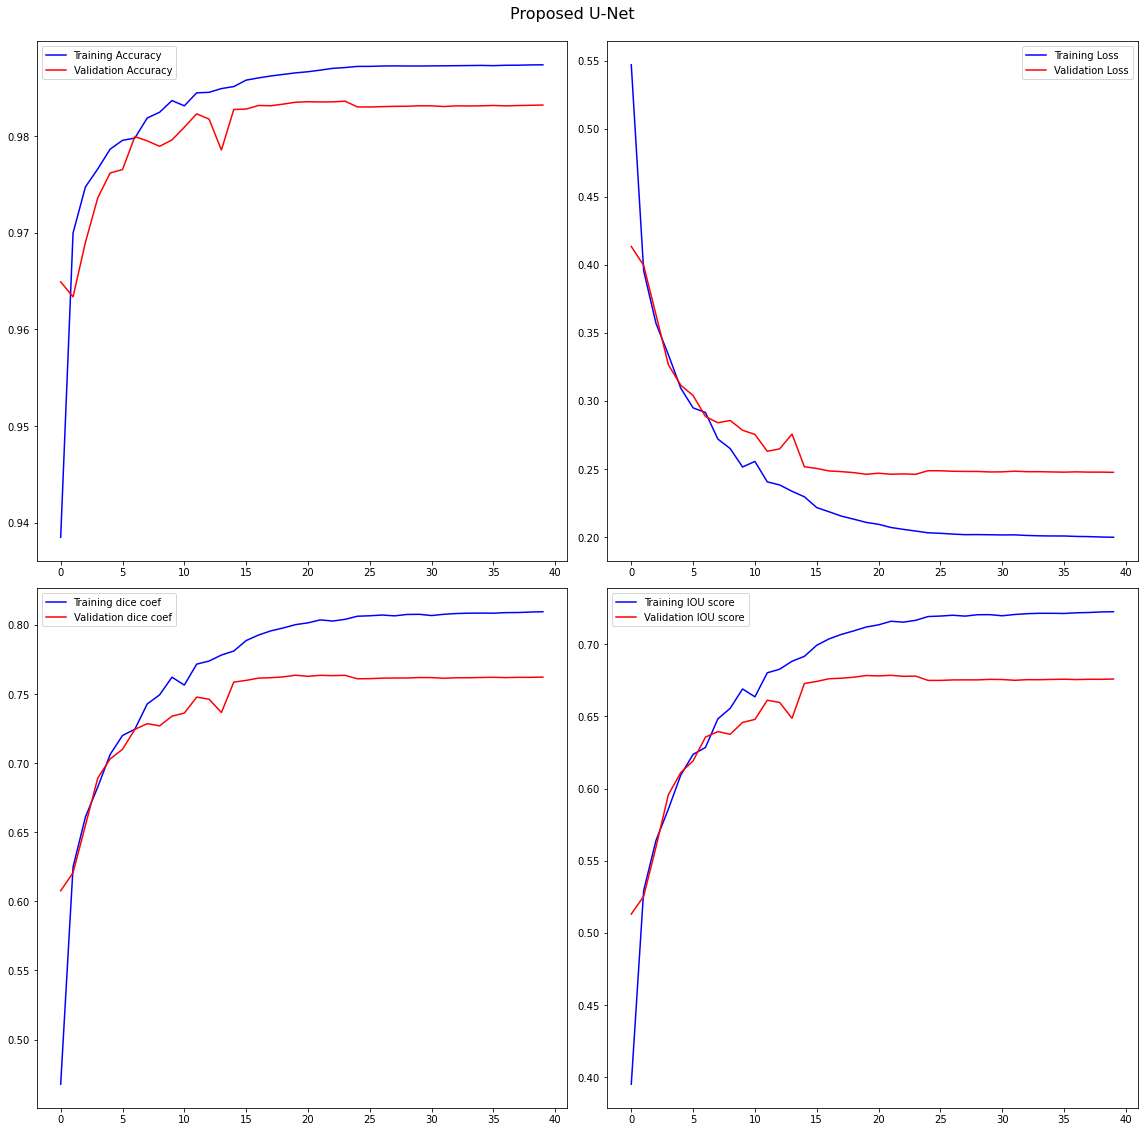

In [6]:
hist_unet_bn_wt = pd.read_csv('saved_models/Unetdo0.1/training_log/training_unet.csv')
#hist_unet_bn = pd.read_csv('saved_models/Unetbn/training_log/training_unet.csv')
#hist_unet = pd.read_csv('saved_models/Unetbnwt/training_log/training_unet.csv')
#hist = hist_df
epoch=range(len(hist_unet_bn_wt))

fig,ax=plt.subplots(2,2,figsize=(16,16))

ax[0,0].plot(epoch,hist_unet_bn_wt['accuracy'],'b',label='Training Accuracy')
ax[0,0].plot(epoch,hist_unet_bn_wt['val_accuracy'],'r',label='Validation Accuracy')
ax[0,0].legend()

ax[0,1].plot(epoch,hist_unet_bn_wt['loss'],'b',label='Training Loss')
ax[0,1].plot(epoch,hist_unet_bn_wt['val_loss'],'r',label='Validation Loss')
ax[0,1].legend()

ax[1,0].plot(epoch,hist_unet_bn_wt['f1-score'],'b',label='Training dice coef')
ax[1,0].plot(epoch,hist_unet_bn_wt['val_f1-score'],'r',label='Validation dice coef')
ax[1,0].legend()

ax[1,1].plot(epoch,hist_unet_bn_wt['iou_score'],'b',label='Training IOU score')
ax[1,1].plot(epoch,hist_unet_bn_wt['val_iou_score'],'r',label='Validation IOU score')
ax[1,1].legend()

plt.suptitle('Proposed U-Net', size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

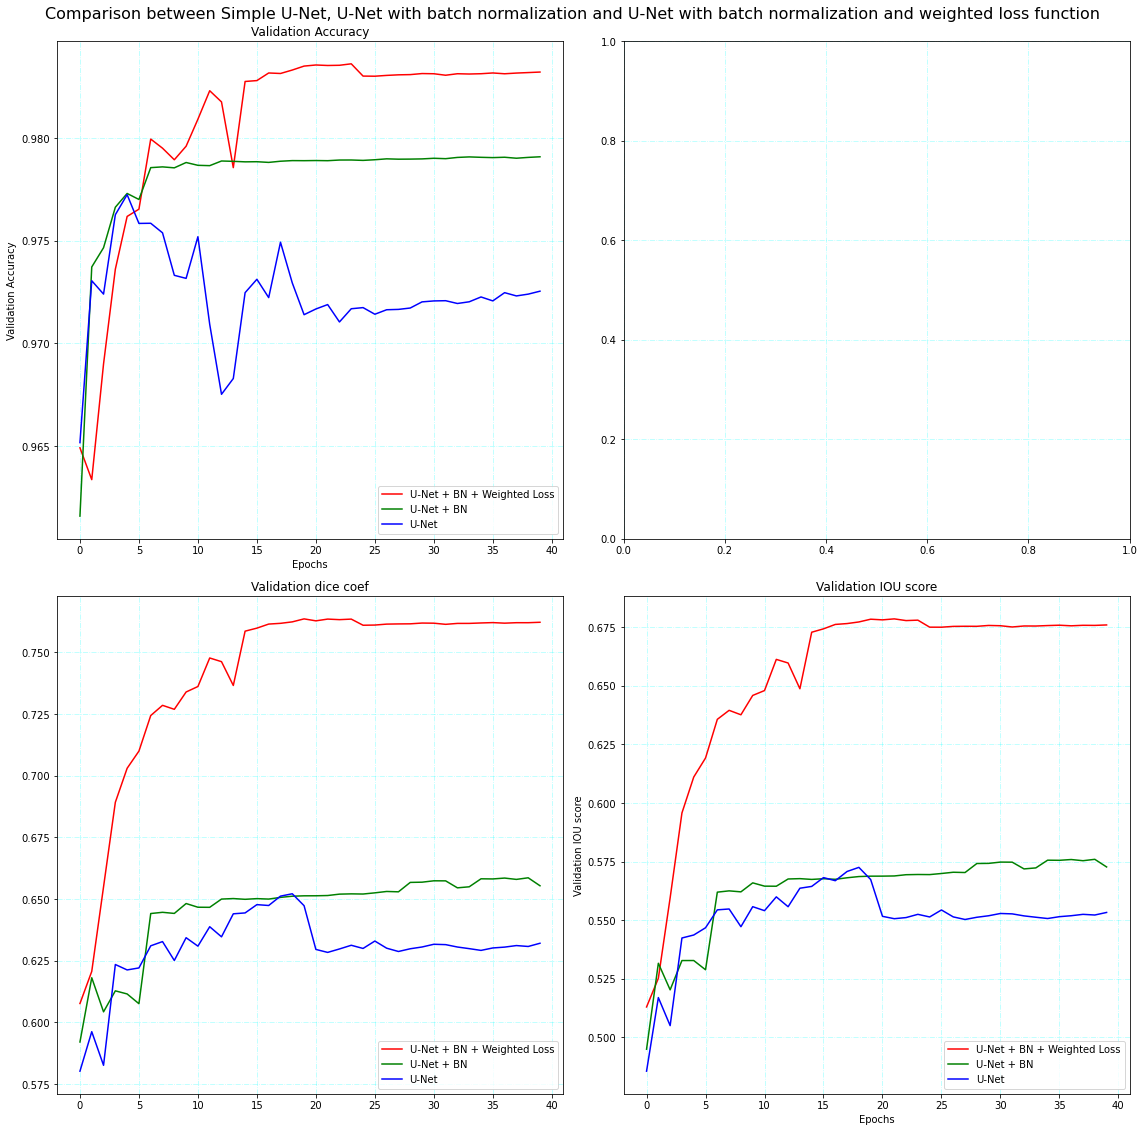

In [17]:
hist_unet_bn_wt = pd.read_csv('saved_models/Unetdo0.1/training_log/training_unet.csv')
hist_unet_bn = pd.read_csv('saved_models/Unetbn/training_log/training_unet.csv')
hist_unet = pd.read_csv('saved_models/Unetbnwt/training_log/training_unet.csv')
#hist = hist_df
epoch=range(len(hist_unet_bn_wt))

fig,ax=plt.subplots(2,2,figsize=(16,16))

ax[0,0].plot(epoch,hist_unet_bn_wt['val_accuracy'],'r',label='U-Net + BN + Weighted Loss')
ax[0,0].plot(epoch,hist_unet_bn['val_accuracy'],'g',label='U-Net + BN')
ax[0,0].plot(epoch,hist_unet['val_accuracy'],'b',label='U-Net')
ax[0,0].set_title('Validation Accuracy')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Validation Accuracy')
ax[0,0].legend()

#ax[0,1].plot(epoch,hist_unet_bn_wt['val_loss'],'r',label='U-Net + BN + Weighted Loss')
#ax[0,1].plot(epoch,hist_unet_bn['val_loss'],'g',label='U-Net + BN')
#ax[0,1].plot(epoch,hist_unet['val_loss'],'b',label='U-Net')
#ax[0,1].set_title('Validation Loss')
#ax[0,1].legend()

ax[1,0].plot(epoch,hist_unet_bn_wt['val_f1-score'],'r',label='U-Net + BN + Weighted Loss')
ax[1,0].plot(epoch,hist_unet_bn['val_f1-score'],'g',label='U-Net + BN')
ax[1,0].plot(epoch,hist_unet['val_f1-score'],'b',label='U-Net')
ax[1,0].set_title('Validation dice coef')
ax[1,0].legend()

ax[1,1].plot(epoch,hist_unet_bn_wt['val_iou_score'],'r',label='U-Net + BN + Weighted Loss')
ax[1,1].plot(epoch,hist_unet_bn['val_iou_score'],'g',label='U-Net + BN')
ax[1,1].plot(epoch,hist_unet['val_iou_score'],'b',label='U-Net')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Validation IOU score')
ax[1,1].set_title('Validation IOU score')
ax[1,1].legend()

plt.suptitle('Comparison between Simple U-Net, U-Net with batch normalization and U-Net with batch normalization and weighted loss function', size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
ax[0,0].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax[0,1].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax[1,0].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax[1,1].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
#plt.savefig('Comparison between Simple U-Net, U-Net with batch normalization.png',transparent=False)
plt.show()


## **Experiments**

#### Dropout = 0.2

In [18]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('unetdo2test_data.hdf5')

Epoch 1/40
240/240 [==============================] - 162s 605ms/step - loss: 0.5481 - accuracy: 0.9539 - iou_score: 0.4014 - f1-score: 0.4769 - val_loss: 0.4994 - val_accuracy: 0.9370 - val_iou_score: 0.4341 - val_f1-score: 0.5237 - lr: 1.0000e-04
Epoch 2/40
240/240 [==============================] - 145s 606ms/step - loss: 0.3997 - accuracy: 0.9705 - iou_score: 0.5236 - f1-score: 0.6190 - val_loss: 0.4317 - val_accuracy: 0.9503 - val_iou_score: 0.4946 - val_f1-score: 0.5898 - lr: 1.0000e-04
Epoch 3/40
240/240 [==============================] - 146s 607ms/step - loss: 0.3809 - accuracy: 0.9726 - iou_score: 0.5423 - f1-score: 0.6378 - val_loss: 0.4010 - val_accuracy: 0.9620 - val_iou_score: 0.5213 - val_f1-score: 0.6173 - lr: 1.0000e-04
Epoch 4/40
240/240 [==============================] - 146s 607ms/step - loss: 0.3500 - accuracy: 0.9758 - iou_score: 0.5699 - f1-score: 0.6672 - val_loss: 0.3709 - val_accuracy: 0.9690 - val_iou_score: 0.5504 - val_f1-score: 0.6455 - lr: 1.0000e-04
Epoc

#### Dropout = 0.3

In [41]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('unetdo0.3.hdf5')

Epoch 1/40
240/240 [==============================] - 148s 606ms/step - loss: 0.5974 - accuracy: 0.9302 - iou_score: 0.3637 - f1-score: 0.4325 - val_loss: 0.4694 - val_accuracy: 0.9590 - val_iou_score: 0.4710 - val_f1-score: 0.5598 - lr: 1.0000e-04
Epoch 2/40
240/240 [==============================] - 146s 607ms/step - loss: 0.4214 - accuracy: 0.9702 - iou_score: 0.5055 - f1-score: 0.5997 - val_loss: 0.4294 - val_accuracy: 0.9570 - val_iou_score: 0.4977 - val_f1-score: 0.5927 - lr: 1.0000e-04
Epoch 3/40
240/240 [==============================] - 146s 608ms/step - loss: 0.3789 - accuracy: 0.9740 - iou_score: 0.5447 - f1-score: 0.6410 - val_loss: 0.4204 - val_accuracy: 0.9579 - val_iou_score: 0.5044 - val_f1-score: 0.6010 - lr: 1.0000e-04
Epoch 4/40
240/240 [==============================] - 146s 608ms/step - loss: 0.3604 - accuracy: 0.9754 - iou_score: 0.5621 - f1-score: 0.6588 - val_loss: 0.3962 - val_accuracy: 0.9644 - val_iou_score: 0.5263 - val_f1-score: 0.6230 - lr: 1.0000e-04
Epoc

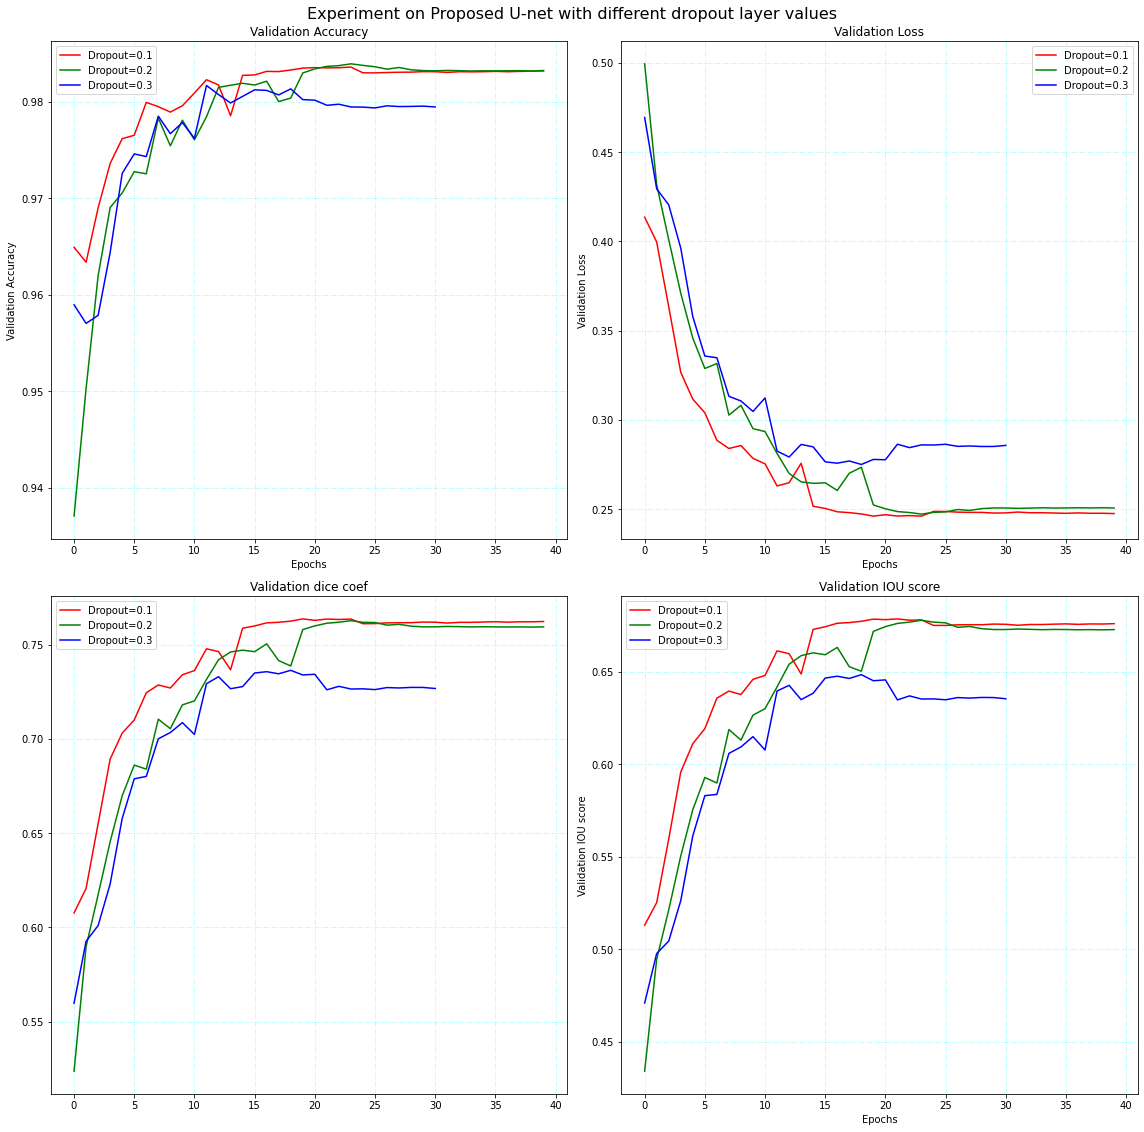

In [16]:
hist_unet_do1 = pd.read_csv('saved_models/Unetdo0.1/training_log/training_unet.csv')
hist_unet_do2 = pd.read_csv('saved_models/Unet/training_log/training_unet.csv')
hist_unet_do3 = pd.read_csv('saved_models/Unetdo0.3/training_log/training_unet.csv')
#hist = hist_df
#epoch=range(len(hist_unet_do1))

fig,ax=plt.subplots(2,2,figsize=(16,16))

ax[0,0].plot(hist_unet_do1['val_accuracy'],'r',label='Dropout=0.1')
ax[0,0].plot(hist_unet_do2['val_accuracy'],'g',label='Dropout=0.2')
ax[0,0].plot(hist_unet_do3['val_accuracy'],'b',label='Dropout=0.3')
ax[0,0].set_title('Validation Accuracy')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Validation Accuracy')
ax[0,0].legend()

ax[0,1].plot(hist_unet_do1['val_loss'],'r',label='Dropout=0.1')
ax[0,1].plot(hist_unet_do2['val_loss'],'g',label='Dropout=0.2')
ax[0,1].plot(hist_unet_do3['val_loss'],'b',label='Dropout=0.3')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Validation Loss')
ax[0,1].set_title('Validation Loss')
ax[0,1].legend()

ax[1,0].plot(hist_unet_do1['val_f1-score'],'r',label='Dropout=0.1')
ax[1,0].plot(hist_unet_do2['val_f1-score'],'g',label='Dropout=0.2')
ax[1,0].plot(hist_unet_do3['val_f1-score'],'b',label='Dropout=0.3')
ax[1,0].set_title('Validation dice coef')
ax[1,0].legend()

ax[1,1].plot(hist_unet_do1['val_iou_score'],'r',label='Dropout=0.1')
ax[1,1].plot(hist_unet_do2['val_iou_score'],'g',label='Dropout=0.2')
ax[1,1].plot(hist_unet_do3['val_iou_score'],'b',label='Dropout=0.3')
ax[1,1].set_title('Validation IOU score')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Validation IOU score')
ax[1,1].legend()

plt.suptitle('Experiment on Proposed U-net with different dropout layer values', size=16)
ax[0,0].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax[0,1].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax[1,0].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax[1,1].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

#### Weight-Initializer = 'he_normal'

In [18]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('unet_he_normal.hdf5')

Epoch 1/40
240/240 [==============================] - 159s 607ms/step - loss: 0.5863 - accuracy: 0.9261 - iou_score: 0.3652 - f1-score: 0.4280 - val_loss: 0.4770 - val_accuracy: 0.9466 - val_iou_score: 0.4643 - val_f1-score: 0.5545 - lr: 1.0000e-04
Epoch 2/40
240/240 [==============================] - 146s 608ms/step - loss: 0.4024 - accuracy: 0.9701 - iou_score: 0.5246 - f1-score: 0.6210 - val_loss: 0.4026 - val_accuracy: 0.9634 - val_iou_score: 0.5227 - val_f1-score: 0.6178 - lr: 1.0000e-04
Epoch 3/40
240/240 [==============================] - 146s 609ms/step - loss: 0.3635 - accuracy: 0.9740 - iou_score: 0.5583 - f1-score: 0.6558 - val_loss: 0.3707 - val_accuracy: 0.9656 - val_iou_score: 0.5534 - val_f1-score: 0.6482 - lr: 1.0000e-04
Epoch 4/40
240/240 [==============================] - 146s 609ms/step - loss: 0.3398 - accuracy: 0.9760 - iou_score: 0.5800 - f1-score: 0.6779 - val_loss: 0.3494 - val_accuracy: 0.9680 - val_iou_score: 0.5748 - val_f1-score: 0.6688 - lr: 1.0000e-04
Epoc

#### Weight-Initializer = 'random_uniform'

In [35]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('unet_random_uniform.hdf5')

Epoch 1/40
240/240 [==============================] - 145s 603ms/step - loss: 0.2141 - accuracy: 0.9863 - iou_score: 0.7060 - f1-score: 0.7949 - val_loss: 0.2670 - val_accuracy: 0.9811 - val_iou_score: 0.6572 - val_f1-score: 0.7442 - lr: 1.0000e-06
Epoch 2/40
240/240 [==============================] - 145s 605ms/step - loss: 0.2143 - accuracy: 0.9864 - iou_score: 0.7058 - f1-score: 0.7949 - val_loss: 0.2673 - val_accuracy: 0.9810 - val_iou_score: 0.6569 - val_f1-score: 0.7440 - lr: 1.0000e-06
Epoch 3/40
240/240 [==============================] - 145s 606ms/step - loss: 0.2138 - accuracy: 0.9864 - iou_score: 0.7064 - f1-score: 0.7954 - val_loss: 0.2670 - val_accuracy: 0.9811 - val_iou_score: 0.6572 - val_f1-score: 0.7442 - lr: 1.0000e-06
Epoch 4/40
240/240 [==============================] - 146s 607ms/step - loss: 0.2137 - accuracy: 0.9864 - iou_score: 0.7064 - f1-score: 0.7954 - val_loss: 0.2670 - val_accuracy: 0.9811 - val_iou_score: 0.6572 - val_f1-score: 0.7443 - lr: 1.0000e-06
Epoc

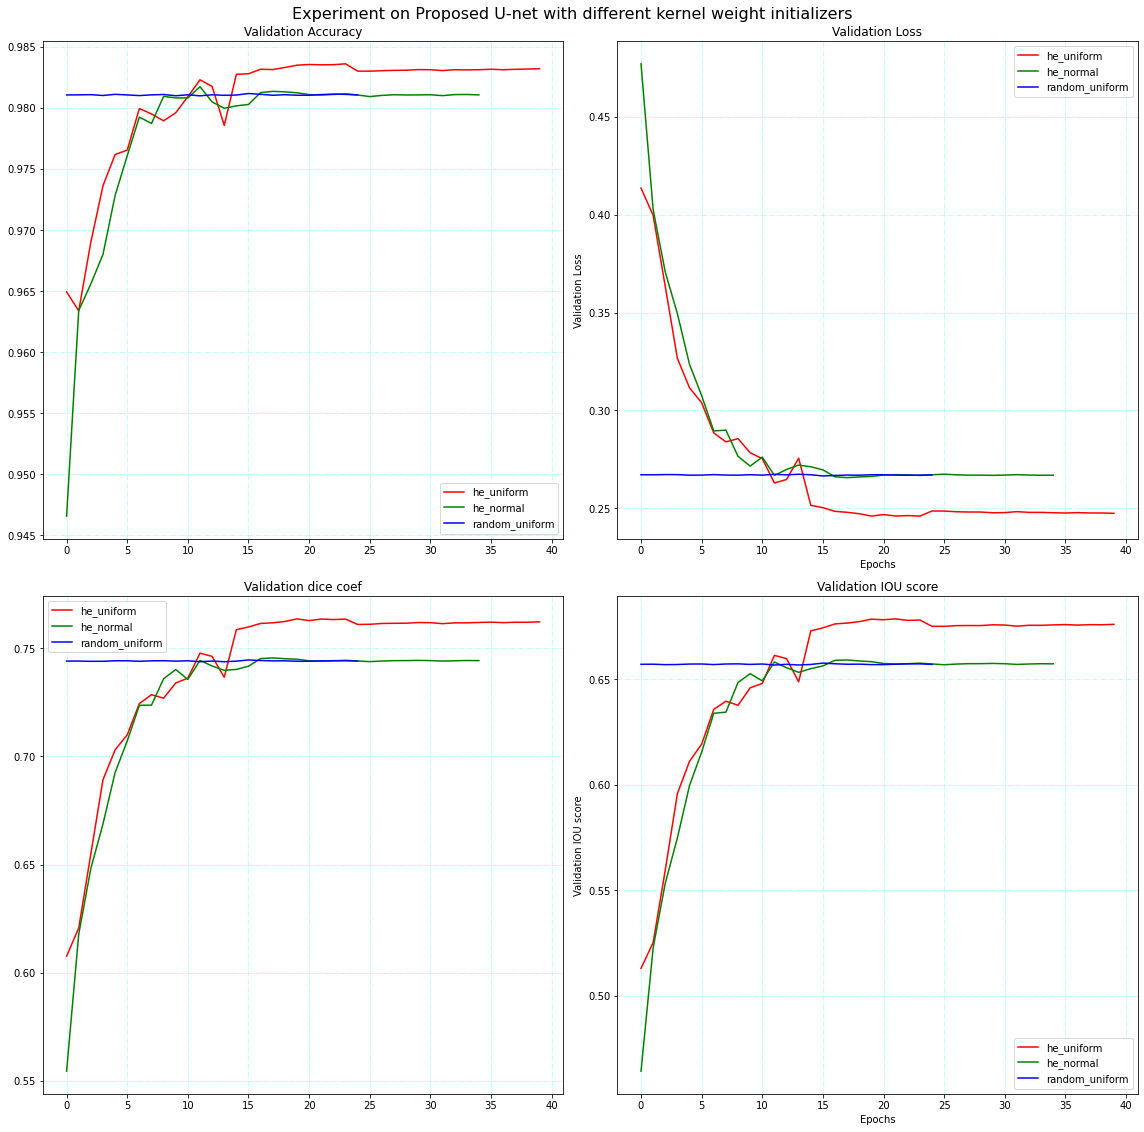

In [15]:
hist_unet_he_uniform = pd.read_csv('saved_models/Unetdo0.1/training_log/training_unet.csv')
hist_unet_he_normal = pd.read_csv('saved_models/Unet_he_normal/training_log/training_unet.csv')
hist_unet_random_uniform = pd.read_csv('saved_models/Unet_random_uniform/training_log/training_unet.csv')
#hist = hist_df
#epoch=range(len(hist_unet_do1))

fig,ax=plt.subplots(2,2,figsize=(16,16))

ax[0,0].plot(hist_unet_he_uniform['val_accuracy'],'r',label='he_uniform')
ax[0,0].plot(hist_unet_he_normal['val_accuracy'],'g',label='he_normal')
ax[0,0].plot(hist_unet_random_uniform['val_accuracy'],'b',label='random_uniform')
ax[0,0].set_title('Validation Accuracy')
ax[0,0].legend()

ax[0,1].plot(hist_unet_he_uniform['val_loss'],'r',label='he_uniform')
ax[0,1].plot(hist_unet_he_normal['val_loss'],'g',label='he_normal')
ax[0,1].plot(hist_unet_random_uniform['val_loss'],'b',label='random_uniform')
ax[0,1].set_ylabel('Validation Loss')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_title('Validation Loss')
ax[0,1].legend()

ax[1,0].plot(hist_unet_he_uniform['val_f1-score'],'r',label='he_uniform')
ax[1,0].plot(hist_unet_he_normal['val_f1-score'],'g',label='he_normal')
ax[1,0].plot(hist_unet_random_uniform['val_f1-score'],'b',label='random_uniform')
ax[1,0].set_title('Validation dice coef')
ax[1,0].legend()

ax[1,1].plot(hist_unet_he_uniform['val_iou_score'],'r',label='he_uniform')
ax[1,1].plot(hist_unet_he_normal['val_iou_score'],'g',label='he_normal')
ax[1,1].plot(hist_unet_random_uniform['val_iou_score'],'b',label='random_uniform')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Validation IOU score')
ax[1,1].set_title('Validation IOU score')
ax[1,1].legend(loc='lower right')

plt.suptitle('Experiment on Proposed U-net with different kernel weight initializers', size=16)
ax[0,0].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax[0,1].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax[1,0].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax[1,1].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

#### Loss Function = Only Categorical Cross Entropy Loss

In [54]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('unetonlycrossentropy.hdf5')


Epoch 1/40
240/240 [==============================] - 147s 603ms/step - loss: 0.4232 - accuracy: 0.8495 - iou_score: 0.2150 - f1-score: 0.2318 - val_loss: 0.1667 - val_accuracy: 0.9587 - val_iou_score: 0.2809 - val_f1-score: 0.3150 - lr: 1.0000e-04
Epoch 2/40
240/240 [==============================] - 145s 604ms/step - loss: 0.0982 - accuracy: 0.9693 - iou_score: 0.3787 - f1-score: 0.4433 - val_loss: 0.1491 - val_accuracy: 0.9572 - val_iou_score: 0.4266 - val_f1-score: 0.4938 - lr: 1.0000e-04
Epoch 3/40
240/240 [==============================] - 145s 602ms/step - loss: 0.0828 - accuracy: 0.9726 - iou_score: 0.4379 - f1-score: 0.5108 - val_loss: 0.1765 - val_accuracy: 0.9518 - val_iou_score: 0.4371 - val_f1-score: 0.5068 - lr: 1.0000e-04
Epoch 4/40
240/240 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9732 - iou_score: 0.4546 - f1-score: 0.5289
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
240/240 [============================

#### Loss Function = Only Categorical Focus loss 

In [35]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('unetonlycategorical.hdf5')

Epoch 1/40
240/240 [==============================] - 147s 603ms/step - loss: 0.0107 - accuracy: 0.8938 - iou_score: 0.2094 - f1-score: 0.2203 - val_loss: 0.0054 - val_accuracy: 0.9545 - val_iou_score: 0.2483 - val_f1-score: 0.2578 - lr: 1.0000e-04
Epoch 2/40
240/240 [==============================] - 152s 634ms/step - loss: 0.0040 - accuracy: 0.9600 - iou_score: 0.2522 - f1-score: 0.2644 - val_loss: 0.0044 - val_accuracy: 0.9660 - val_iou_score: 0.2636 - val_f1-score: 0.2926 - lr: 1.0000e-04
Epoch 3/40
240/240 [==============================] - 146s 607ms/step - loss: 0.0028 - accuracy: 0.9689 - iou_score: 0.3407 - f1-score: 0.4011 - val_loss: 0.0039 - val_accuracy: 0.9650 - val_iou_score: 0.3818 - val_f1-score: 0.4535 - lr: 1.0000e-04
Epoch 4/40
240/240 [==============================] - 146s 608ms/step - loss: 0.0024 - accuracy: 0.9725 - iou_score: 0.4039 - f1-score: 0.4805 - val_loss: 0.0034 - val_accuracy: 0.9664 - val_iou_score: 0.4046 - val_f1-score: 0.4763 - lr: 1.0000e-04
Epoc

#### Loss Function = Only Dice Score (without weights)

In [17]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('unetonlydice.hdf5')

Epoch 1/40
240/240 [==============================] - 157s 598ms/step - loss: 0.7597 - accuracy: 0.8697 - iou_score: 0.2205 - f1-score: 0.2377 - val_loss: 0.7312 - val_accuracy: 0.9436 - val_iou_score: 0.2509 - val_f1-score: 0.2711 - lr: 1.0000e-04
Epoch 2/40
240/240 [==============================] - 169s 702ms/step - loss: 0.5563 - accuracy: 0.9552 - iou_score: 0.3751 - f1-score: 0.4497 - val_loss: 0.4879 - val_accuracy: 0.9397 - val_iou_score: 0.4288 - val_f1-score: 0.5183 - lr: 1.0000e-04
Epoch 3/40
240/240 [==============================] - 144s 599ms/step - loss: 0.4044 - accuracy: 0.9668 - iou_score: 0.5075 - f1-score: 0.6017 - val_loss: 0.4049 - val_accuracy: 0.9613 - val_iou_score: 0.5041 - val_f1-score: 0.5974 - lr: 1.0000e-04
Epoch 4/40
240/240 [==============================] - 144s 600ms/step - loss: 0.3706 - accuracy: 0.9718 - iou_score: 0.5389 - f1-score: 0.6347 - val_loss: 0.3674 - val_accuracy: 0.9683 - val_iou_score: 0.5402 - val_f1-score: 0.6340 - lr: 1.0000e-04
Epoc

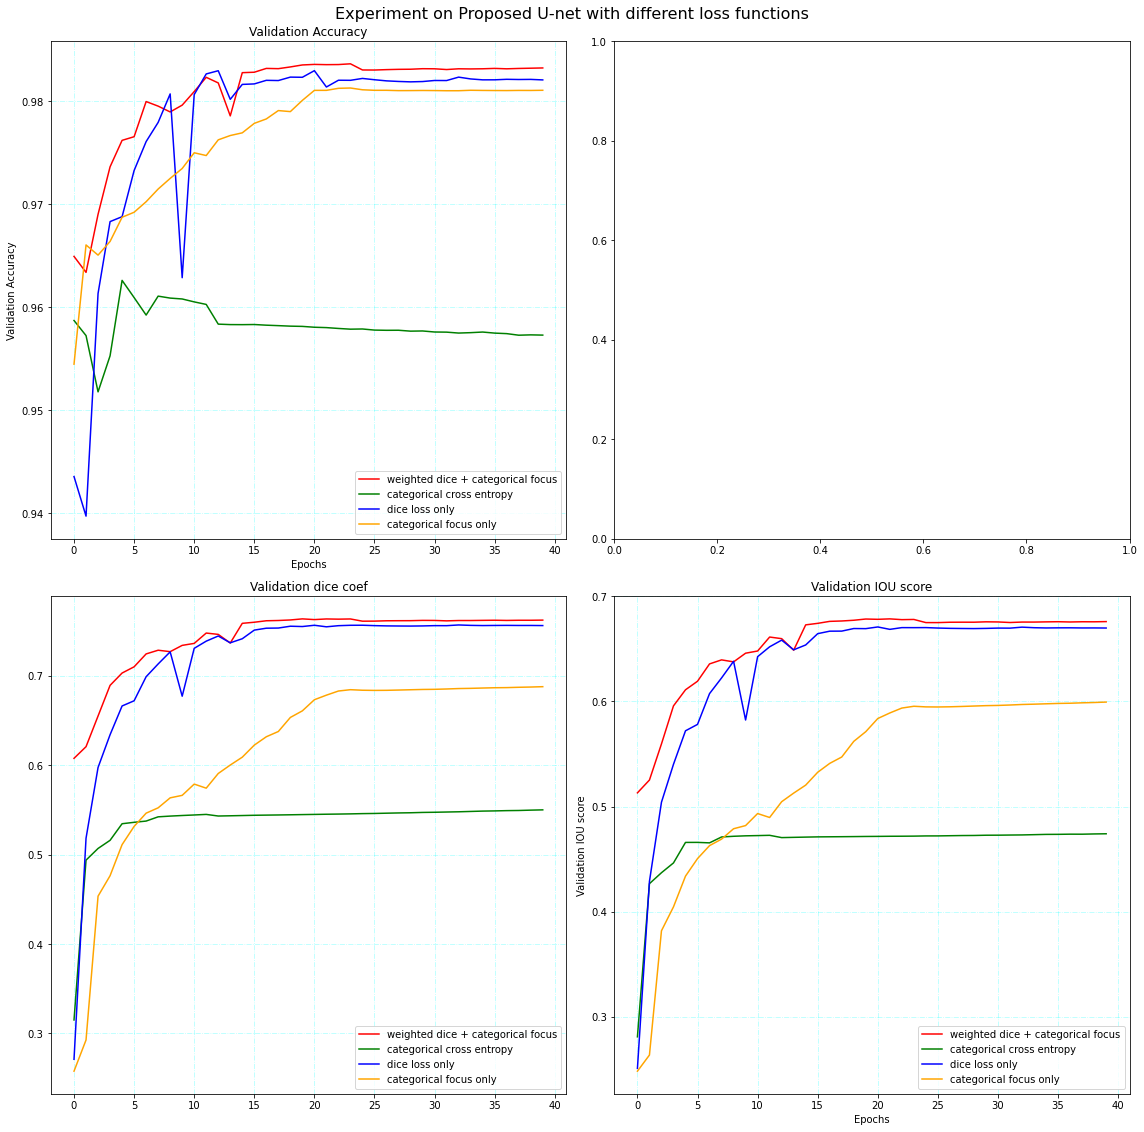

In [6]:
hist_unet = pd.read_csv('saved_models/Unetdo0.1/training_log/training_unet.csv')
hist_unet_cat_crossentropy = pd.read_csv('saved_models/Unetonlycrossentropy/training_log/training_unet.csv')
hist_unet_dice = pd.read_csv('saved_models/Unetonlydice/training_log/training_unet.csv')
hist_unet_cat_focus = pd.read_csv('saved_models/Unetonlyjaccard/training_log/training_unet.csv')

#hist = hist_df
#epoch=range(len(hist_unet_do1))

fig,ax=plt.subplots(2,2,figsize=(16,16))

ax[0,0].plot(hist_unet['val_accuracy'],'r',label='weighted dice + categorical focus')
ax[0,0].plot(hist_unet_cat_crossentropy['val_accuracy'],'g',label='categorical cross entropy')
ax[0,0].plot(hist_unet_dice['val_accuracy'],'b',label='dice loss only')
ax[0,0].plot(hist_unet_cat_focus['val_accuracy'],'orange',label='categorical focus only')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Validation Accuracy')
ax[0,0].set_title('Validation Accuracy')
ax[0,0].legend()

#ax[0,1].plot(hist_unet['val_loss'],'r',label='weighted dice + categorical focus')
#ax[0,1].plot(hist_unet_cat_crossentropy['val_loss'],'g',label='categorical cross entropy')
#ax[0,1].plot(hist_unet_dice['val_loss'],'b',label='dice loss only')
#ax[0,1].plot(hist_unet_cat_focus['val_loss'],'orange',label='categorical focus only')
#ax[0,1].set_title('Validation Loss')
#ax[0,1].legend()

ax[1,0].plot(hist_unet['val_f1-score'],'r',label='weighted dice + categorical focus')
ax[1,0].plot(hist_unet_cat_crossentropy['val_f1-score'],'g',label='categorical cross entropy')
ax[1,0].plot(hist_unet_dice['val_f1-score'],'b',label='dice loss only')
ax[1,0].plot(hist_unet_cat_focus['val_f1-score'],'orange',label='categorical focus only')
ax[1,0].set_title('Validation dice coef')
ax[1,0].legend()

ax[1,1].plot(hist_unet['val_iou_score'],'r',label='weighted dice + categorical focus')
ax[1,1].plot(hist_unet_cat_crossentropy['val_iou_score'],'g',label='categorical cross entropy')
ax[1,1].plot(hist_unet_dice['val_iou_score'],'b',label='dice loss only')
ax[1,1].plot(hist_unet_cat_focus['val_iou_score'],'orange',label='categorical focus only')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Validation IOU score')
ax[1,1].set_title('Validation IOU score')
ax[1,1].legend(loc='lower right')

plt.suptitle('Experiment on Proposed U-net with different loss functions', size=16)
ax[0,0].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
#ax[0,1].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax[1,0].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
ax[1,1].grid(visible=True, color='aqua', alpha=0.3, linestyle='dashdot')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Load model and test

In [8]:
from keras.models import load_model
model = load_model('unetdo0.1.hdf5', 
                      compile=False)

In [9]:
test_img_dir = "train_val_test/test/images/"
test_mask_dir = "train_val_test/test/masks/"

test_img_list=os.listdir(test_img_dir)
test_mask_list = os.listdir(test_mask_dir)
batch_size=1 
test_img_datagen = imageLoader(test_img_dir, test_img_list, 
                                test_mask_dir, test_mask_list, batch_size)


#### Mean IOU and IOU scores for each class (model without weighted loss)

In [29]:
from keras.metrics import MeanIoU
batch_size=1 
#test_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
for i in range(0,len(test_img_list)):
    test_image_batch, test_mask_batch = test_img_datagen.__next__()
    test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
    test_pred_batch = model.predict(test_image_batch, verbose =0)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)
    IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
    
mean_iou = IOU_keras.result().numpy()

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class0_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3]+ values[1,0]+ values[2,0]+ values[3,0])
class1_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3]+ values[0,1]+ values[2,1]+ values[3,1])
class2_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3]+ values[0,2]+ values[1,2]+ values[3,2])
class3_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2]+ values[0,3]+ values[1,3]+ values[2,3])
print('NOT tumor: {:.2f}%\nNECROTIC/CORE: {:.2f}%\nEDEMA: {:.2f}%\nENHANCING: {:.2f}%'.format(class0_IoU*100,class1_IoU*100, class2_IoU*100, class3_IoU*100))
print("Mean IoU =",(class0_IoU +class1_IoU+ class2_IoU+ class3_IoU)/4)

NOT tumor: 98.86%
NECROTIC/CORE: 54.90%
EDEMA: 63.54%
ENHANCING: 67.34%
Mean IoU = 0.7115939855575562


#### Mean IOU and IOU scores for each class (Proposed model with weighted loss)

In [42]:
from keras.metrics import MeanIoU
batch_size=1 
#test_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
for i in range(0,len(test_img_list)):
    test_image_batch, test_mask_batch = test_img_datagen.__next__()
    test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
    test_pred_batch = model.predict(test_image_batch, verbose =0)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)
    IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
    
mean_iou = IOU_keras.result().numpy()

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class0_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3]+ values[1,0]+ values[2,0]+ values[3,0])
class1_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3]+ values[0,1]+ values[2,1]+ values[3,1])
class2_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3]+ values[0,2]+ values[1,2]+ values[3,2])
class3_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2]+ values[0,3]+ values[1,3]+ values[2,3])
print('NOT tumor: {:.2f}%\nNECROTIC/CORE: {:.2f}%\nEDEMA: {:.2f}%\nENHANCING: {:.2f}%'.format(class0_IoU*100,class1_IoU*100, class2_IoU*100, class3_IoU*100))
print("Mean IoU =",(class0_IoU +class1_IoU+ class2_IoU+ class3_IoU)/4)

NOT tumor: 98.95%
NECROTIC/CORE: 60.98%
EDEMA: 65.46%
ENHANCING: 67.49%
Mean IoU = 0.7321920394897461


In [25]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class0_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3]+ values[1,0]+ values[2,0]+ values[3,0])
class1_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3]+ values[0,1]+ values[2,1]+ values[3,1])
class2_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3]+ values[0,2]+ values[1,2]+ values[3,2])
class3_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2]+ values[0,3]+ values[1,3]+ values[2,3])
print('NOT tumor: {:.2f}%\nNECROTIC/CORE: {:.2f}%\nEDEMA: {:.2f}%\nENHANCING: {:.2f}%'.format(class0_IoU*100,class1_IoU*100, class2_IoU*100, class3_IoU*100))
print("Mean IoU =",(class0_IoU +class1_IoU+ class2_IoU+ class3_IoU)/4)

NOT tumor: 98.98%
NECROTIC/CORE: 61.45%
EDEMA: 64.82%
ENHANCING: 67.13%
Mean IoU = 0.7309431433677673


### Prediction example

In [53]:
#Try images: 
img_num = 211

test_img = np.load("train_val_test/test/images/image_"+str(img_num)+".npy")

test_mask = np.load("train_val_test/test/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 0s 40ms/step


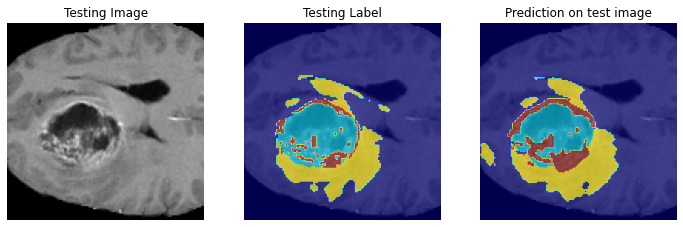

In [58]:
n_slice = 72
fig = plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.axis('off')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.imshow(test_mask_argmax[:,:,n_slice], cmap='jet',alpha=0.6)
plt.axis('off')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.imshow(test_prediction_argmax[:,:,n_slice], cmap='jet',alpha=0.6)
plt.axis('off')
plt.show()